### Info
Plotting comparisons

In [2]:
import numpy as np
import pandas as pd

### Load data into a DataFrame

In [3]:
min_ind = 1
max_ind = 2

model_names = ('hls','qkeras','qonnx_init','qonnx_mod')
pred_all = []   # will be a list of arrays from each model

for model_name in model_names:
    pred_single = np.array([])
    for file_index in range(min_ind, max_ind+1):
        data = np.load('./pred_Test_corr/preds_'+model_name+str(file_index)+'.npy')
        pred_single = np.append(pred_single,data)
        #print(pred_single.shape)
    pred_all.append(pred_single)

pred_all = np.array(pred_all).T

In [4]:
pred_all.shape

(4096, 4)

In [5]:
df = pd.DataFrame(pred_all, columns=model_names)
df

,hls,qkeras,qonnx_init,qonnx_mod
0,2.375,2.750,2.750,2.750
1,0.625,0.875,0.875,0.875
2,1.500,1.750,1.750,1.750
3,0.750,1.000,1.000,1.000
4,29.500,28.875,28.875,28.875
...,...,...,...,...
4091,0.250,0.375,0.375,0.375
4092,1.875,1.875,1.875,1.750
4093,2.250,2.500,2.500,2.500
4094,2.250,2.375,2.375,2.375


### Compare predictions

In [6]:
df['qxinit_qkeras'] = np.abs(df['qonnx_init'] - df['qkeras'])
df['qxinit_qkeras'].value_counts()

qxinit_qkeras
0.0    4096
Name: count, dtype: int64

modified vs unmodified qonnx with respect to hls

In [7]:
df['qxinit_hls'] = np.abs(df['qonnx_init'] - df['hls'])
df['qxmod_hls'] = np.abs(df['qonnx_mod'] - df['hls'])

print(df['qxinit_hls'].value_counts())
print(df['qxmod_hls'].value_counts())

qxinit_hls
0.125    1667
0.250    1478
0.000     502
0.375     397
0.500      45
0.625       3
0.750       3
1.375       1
Name: count, dtype: int64
qxmod_hls
0.250    1553
0.125    1213
0.000     777
0.375     357
0.500     159
0.625      29
0.750       4
2.000       1
1.250       1
1.000       1
1.500       1
Name: count, dtype: int64


### Create histograms

In [8]:
import matplotlib.pyplot as plt

In [9]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl = dfpl.transpose()
dfpl.columns = ['init','mod']
dfpl = dfpl.fillna(0)
dfpl /= dfpl['init'].sum()  # percentage
dfpl *= 100
dfpl = dfpl.sort_index()
dfpl

,init,mod
0.000,12.255859,18.969727
0.125,40.698242,29.614258
0.250,36.083984,37.915039
0.375,9.692383,8.715820
0.500,1.098633,3.881836
0.625,0.073242,0.708008
0.750,0.073242,0.097656
1.000,0.000000,0.024414
1.250,0.000000,0.024414
1.375,0.024414,0.000000


In [10]:
def categ(x):
    if x==0.0 : return '0.0'
    if x < 0.5 : return '0.0 - 0.5'
    if x < 1.0 : return '0.5 - 1.0'
    return '1.0 - 2.0'

In [11]:
# Categorize differences (deviations from hls preds)
dfpl['cat'] = dfpl.index.map(categ)

catdf = dfpl.groupby('cat').sum()
catdf

,init,mod
cat,,
0.0,12.255859,18.969727
0.0 - 0.5,86.474609,76.245117
0.5 - 1.0,1.245117,4.687500
1.0 - 2.0,0.024414,0.097656


In [12]:
#catdf = catdf.reindex(['0.0','0 - 1','1 - 5','5 - 10','10 - 15'])
catdf

,init,mod
cat,,
0.0,12.255859,18.969727
0.0 - 0.5,86.474609,76.245117
0.5 - 1.0,1.245117,4.687500
1.0 - 2.0,0.024414,0.097656


Text(0.5, 1.0, 'Background')

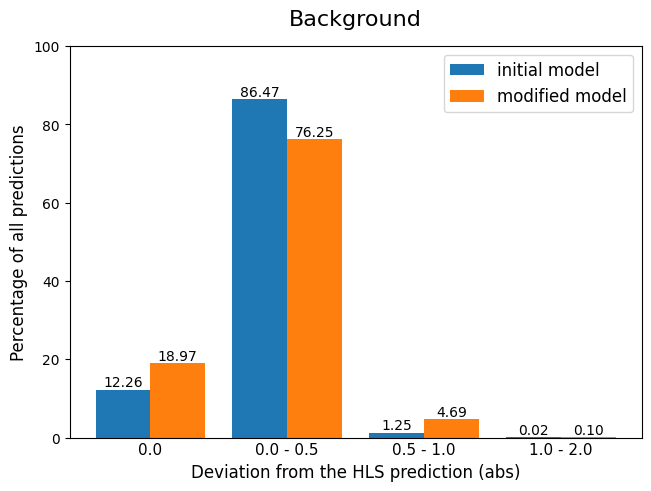

In [13]:
fig, ax = plt.subplots(layout='constrained')
width = 0.4
xticks = np.arange(catdf.shape[0])

labels = ["initial model","modified model"]

for i in range(len(catdf.keys())):
    b = ax.bar(xticks+(-1+i)*width, catdf.values[:,i], width, label=labels[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend(fontsize = 12)
ax.set_xticks(xticks)
ax.set_xticklabels(catdf.index.to_list(),fontdict={'size': 11})
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel("Deviation from the HLS prediction (abs)",{'size': 12})
ax.set_ylim(0,100)
ax.set_ylabel("Percentage of all predictions",{'size': 12})
ax.set_title("Background",fontdict={'size': 16},pad=15)


In [14]:
fig.savefig('Bgd.pdf')